In [ ]:
!pip install scikit-learn==1.5.2

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import seaborn as sns


# Step 1: Load the dataset
file_path = '/content/updated_investments_VC.csv'
updated_investments_df = pd.read_csv(file_path)


In [ ]:
updated_investments_df.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,funding_growth_rate
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,...,0,1,1,1,1,1,1,1,1,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,4000000.0,operating,USA,CA,Los Angeles,...,0,1,1,1,1,1,1,1,1,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,operating,EST,NaN,Tallinn,...,0,1,1,1,1,1,1,1,1,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,NaN,London,...,0,1,1,1,1,1,1,1,1,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,TX,Dallas,...,0,1,1,1,1,1,1,1,1,0.0


In [ ]:
updated_investments_df['status'].value_counts()

,count
status,
operating,41829
acquired,3692
closed,2603


Problem: 'status'== 'operating' does not give us a good understanding of the situation of the company since the company can be operating under a loss.
Hypothesis: We can use total_funding as a proxy for investors' trust in the growth of the company and assign them as successful if there total funding is near the average funding of acquired companies and unsuccessful otherwise.

In [ ]:

mean_funding_closed = updated_investments_df[updated_investments_df['status'] == 'closed']['funding_total_usd'].mean()
mean_funding_acquired = updated_investments_df[updated_investments_df['status'] == 'acquired']['funding_total_usd'].mean()

In [ ]:
round(mean_funding_closed, 2), round(mean_funding_acquired, 2)

(7023193.73, 20755781.93)

In [ ]:
mean_funding_operating = updated_investments_df[updated_investments_df['status'] == 'operating']['funding_total_usd'].mean()
round(mean_funding_operating,2)

12952444.4

makes sense till this point since mean_funding_acquired > mean_funding_operating > mean_funding_closed

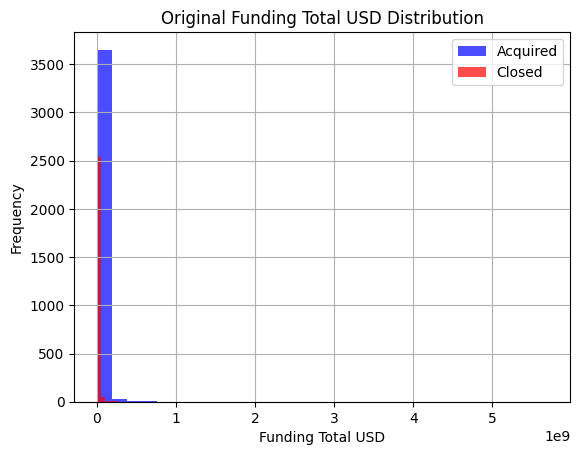

In [ ]:
#ploting the total funding histograms:

funding_acquired = updated_investments_df[updated_investments_df['status'] == 'acquired']['funding_total_usd']
funding_closed = updated_investments_df[updated_investments_df['status'] == 'closed']['funding_total_usd']

funding_acquired.hist(bins=30, alpha=0.7, color='blue', label='Acquired')
funding_closed.hist(bins=30, alpha=0.7, color='red', label='Closed')

plt.xlabel('Funding Total USD')
plt.ylabel('Frequency')
plt.title('Original Funding Total USD Distribution')
plt.legend()
plt.show()

percentage within acquired: 85.16%
percentage within closed: 66.00%
percentage within operating: 70.32%
##############################################################
percentage within acquired: 60.48%
percentage within closed: 57.82%
percentage within operating: 58.39%


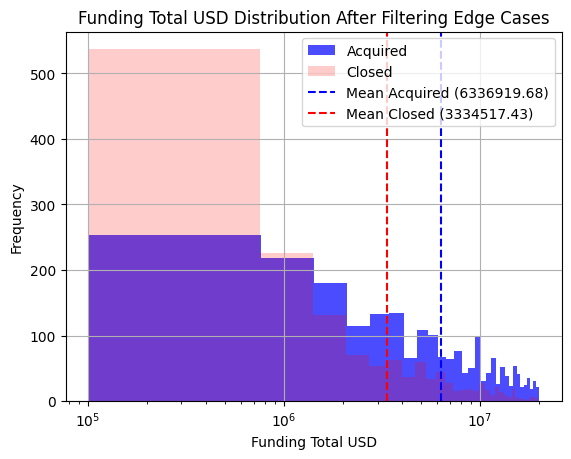

In [ ]:
import matplotlib.pyplot as plt

# Calculate the mean funding for 'acquired' and 'closed' companie

# Create a histogram for 'acquired' companiesj
funding_acquired = updated_investments_df[updated_investments_df['status'] == 'acquired']['funding_total_usd']
funding_closed = updated_investments_df[updated_investments_df['status'] == 'closed']['funding_total_usd']
funding_operating = updated_investments_df[updated_investments_df['status'] == 'operating']['funding_total_usd']

prev_len_acquired = len(funding_acquired)
prev_len_closed = len(funding_closed)
prev_len_operating = len(funding_operating)

#removing companies with 0
funding_acquired = funding_acquired[funding_acquired > 1e5]
funding_closed = funding_closed[funding_closed > 1e5]
funding_operating = funding_operating[funding_operating > 1e5]

print(f'percentage within acquired: {len(funding_acquired)/prev_len_acquired*100:.2f}%')
print(f'percentage within closed: {len(funding_closed)/prev_len_closed*100:.2f}%')
print(f'percentage within operating: {len(funding_operating)/prev_len_operating*100:.2f}%')
print("##############################################################")

# prev_len_acquired = len(funding_acquired)
# prev_len_closed = len(funding_closed)
# prev_len_operating = len(funding_operating)


#cutting off at a threshold
thresh = 2e7
funding_acquired = funding_acquired[funding_acquired < thresh]
funding_closed = funding_closed[funding_closed < thresh]
funding_operating = funding_operating[funding_operating < thresh]

print(f'percentage within acquired: {len(funding_acquired)/prev_len_acquired*100:.2f}%')
print(f'percentage within closed: {len(funding_closed)/prev_len_closed*100:.2f}%')
print(f'percentage within operating: {len(funding_operating)/prev_len_operating*100:.2f}%')

mean_funding_acquired = funding_acquired.mean()
mean_funding_closed = funding_closed.mean()
mean_funding_operating = funding_operating.mean()

#plotting the mean funding in the histogram
# Add vertical lines for means, with log-transform
funding_acquired.hist(bins=30, alpha=0.7, color='blue', label='Acquired')
plt.xscale('log')
funding_closed.hist(bins=30, alpha=0.2, color='red', label='Closed')
plt.xscale('log')
# funding_operating.hist(bins=30, alpha=0.2, color='green', label='Operating')


plt.axvline(mean_funding_acquired, color='blue', linestyle='dashed', linewidth=1.5,
            label=f'Mean Acquired ({mean_funding_acquired:.2f})')
plt.axvline(mean_funding_closed, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean Closed ({mean_funding_closed:.2f})')

plt.xlabel('Funding Total USD')
plt.ylabel('Frequency')
plt.title('Funding Total USD Distribution After Filtering Edge Cases')
plt.legend(loc='upper right')
plt.show()


In [ ]:
len(funding_acquired), len(funding_closed), len(funding_operating)

(2233, 1505, 24426)

In [ ]:
df = updated_investments_df[updated_investments_df['status'] != 'operating']

In [ ]:
updated_investments_df.columns

Index(['permalink', 'name', 'homepage_url', 'category_list', 'market',
       'funding_total_usd', 'status', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'funding_growth_rate'],
      dtype='object')

In [ ]:
#remove permalink, homepage_url and funding_growth_rate
updated_investments_df.drop(columns=['permalink', 'homepage_url', 'funding_growth_rate'], inplace=True)


In [ ]:
updated_investments_df['category_list']


,category_list
0,|Entertainment|Politics|Social Media|News|
1,|Games|
2,|Publishing|Education|
3,|Electronics|Guides|Coffee|Restaurants|Music|i...
4,|Tourism|Entertainment|Games|
...,...
49433,|Analytics|Gamification|Developer APIs|iOS|And...
49434,|Enterprise Software|
49435,|Web Development|Advertising|Wireless|Mobile|
49436,|Games|


In [ ]:
df = updated_investments_df.copy()

orig_len = len(df)

#only keep the rows with 'funding_total_usd' > 1e5 #and <2e7
df = df[(df['funding_total_usd'] > 1e5)]# & (df['funding_total_usd'] < 2e7)]

print(f'percentage of data kept: {len(df)/orig_len*100:.2f}%')
#we are losing about 30% data when we are dropping all data <1e5


percentage of data kept: 71.11%


In [ ]:
len(df)

35155

In [ ]:
df['status'].value_counts()

,count
status,
operating,29413
acquired,3144
closed,1718


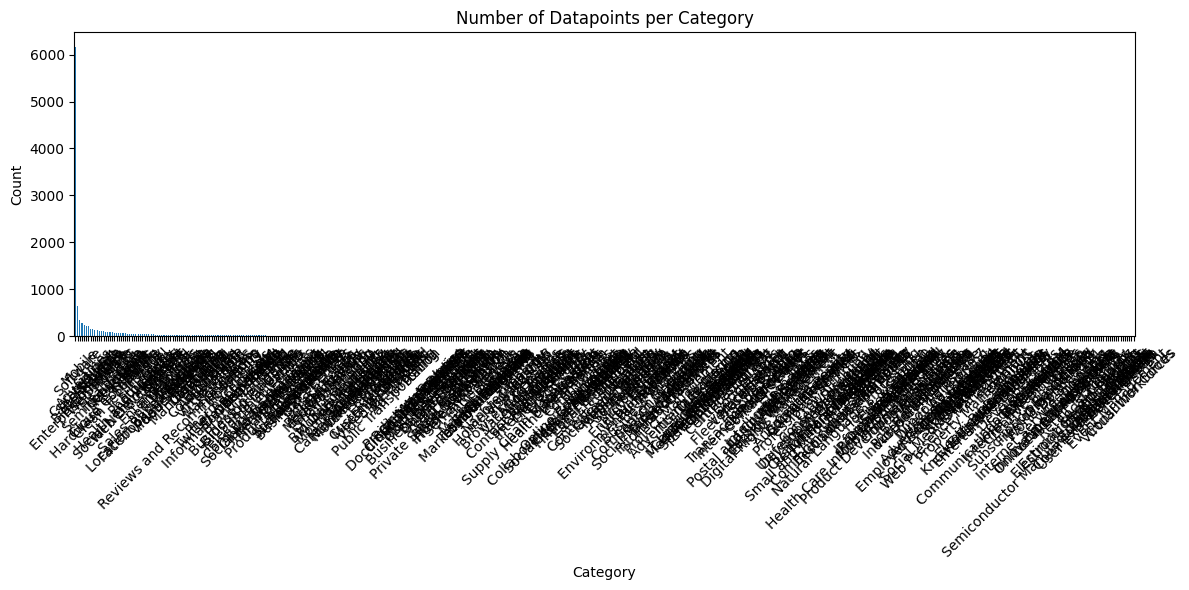

In [ ]:
import pandas as pd

# Split the strings into categories
categories = df[df['status']=='acquired']['category_list'].str.split('|').explode()

#print(categories)
# Count the occurrences of each category
category_counts = categories.value_counts()

plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Number of Datapoints per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
categories.value_counts()

,count
category_list,
,6168
Software,633
Mobile,334
Enterprise Software,289
Curated Web,239
...,...
Comics,1
Printing,1
Virtual Workforces,1


In [ ]:
#only keeping categories with value_counts > thresh
thresh=100
filtered_categories = categories[categories.isin(categories.value_counts()[categories.value_counts() > thresh].index)]

#removing "" category
filtered_categories = filtered_categories[filtered_categories != ""]

In [ ]:
filtered_categories.value_counts()

,count
category_list,
Software,633
Mobile,334
Enterprise Software,289
Curated Web,239
Advertising,217
Biotechnology,213
Social Media,158
Games,155
E-Commerce,129


In [ ]:
len(categories.value_counts()), len(filtered_categories.value_counts())

(491, 12)

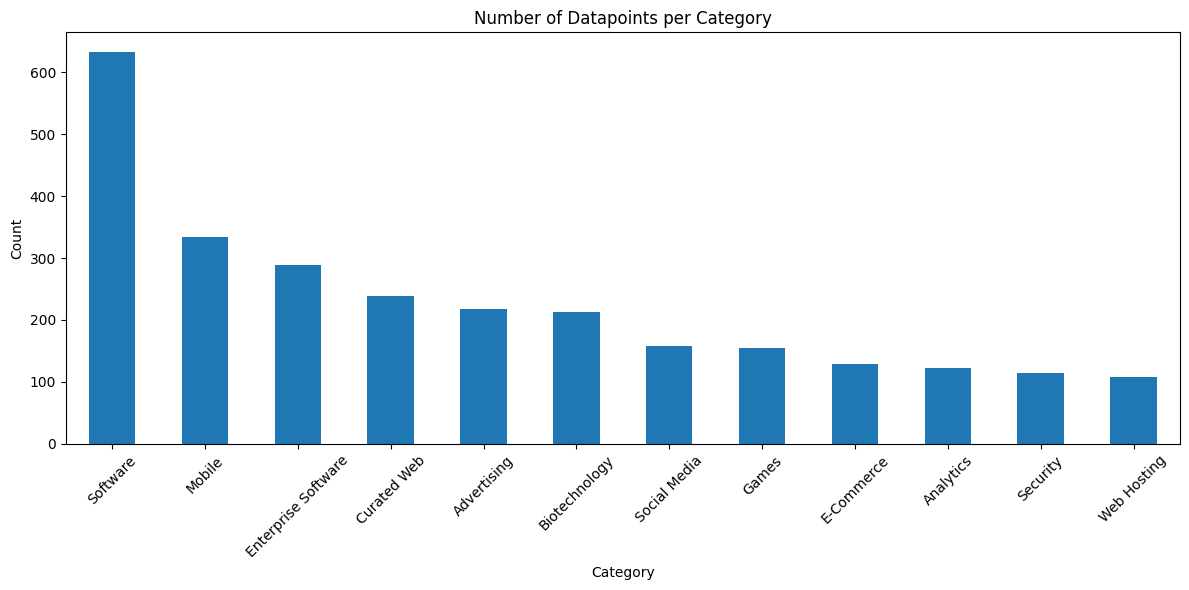

In [ ]:
category_counts = filtered_categories.value_counts()

plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Number of Datapoints per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
categories_to_keep = filtered_categories.value_counts().keys()

In [ ]:
df['category_list'] = df['category_list'].replace('other').fillna('Other')
df['category_list'] = df['category_list'].apply(
    lambda x: '|'.join([cat if cat in categories_to_keep else 'Other' for cat in x.split('|')])
)

# Split the adjusted category list into individual categories and create dummies
df['categories'] = df['category_list'].str.split('|')
categories = df['category_list'].str.split('|')

dummies = pd.get_dummies(categories.apply(pd.Series).stack()).groupby(level=0).sum()


<ipython-input-167-1752eb6f24b2>:1: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df['category_list'] = df['category_list'].replace('other').fillna('Other')


In [ ]:
cat = df['categories'].explode()

In [ ]:
df['categories']

,categories
0,"[Other, Other, Other, Social Media, Other, Other]"
1,"[Other, Games, Other]"
3,"[Other, Other, Other, Other, Other, Other, Oth..."
5,"[Other, Software, Other]"
6,"[Other, Advertising, Other]"
...,...
49432,"[Other, Biotechnology, Other]"
49433,"[Other, Analytics, Other, Other, Other, Other,..."
49434,"[Other, Enterprise Software, Other]"
49436,"[Other, Games, Other]"


In [ ]:
df['categories']

,categories
0,"[Other, Other, Other, Social Media, Other, Other]"
1,"[Other, Games, Other]"
3,"[Other, Other, Other, Other, Other, Other, Oth..."
5,"[Other, Software, Other]"
6,"[Other, Advertising, Other]"
...,...
49432,"[Other, Biotechnology, Other]"
49433,"[Other, Analytics, Other, Other, Other, Other,..."
49434,"[Other, Enterprise Software, Other]"
49436,"[Other, Games, Other]"


In [ ]:
#naming all markets which have frequence less than 250 as 'others'
market_counts = df['market'].value_counts()
low_frequency_markets = market_counts[market_counts < 250].index

# Replace low-frequency markets with 'others'
df_nn = df.copy()
df_nn['market'] = df['market'].apply(lambda x: 'others' if x in low_frequency_markets else x)



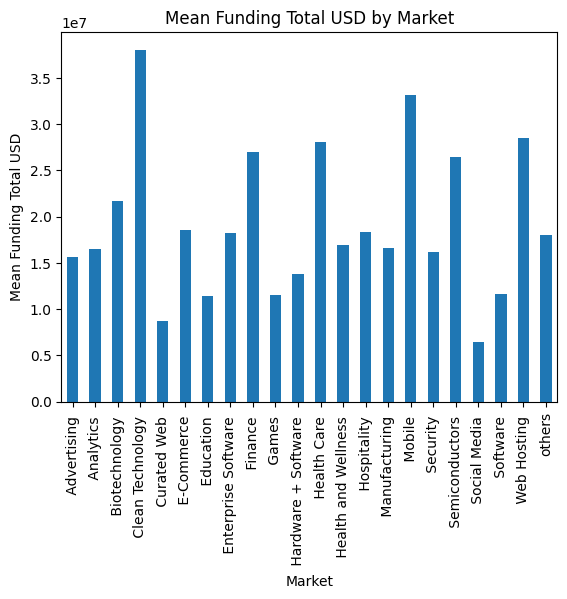

In [ ]:
#finding funding_total_usd mean for each category
mean_funding_by_category = df_nn.groupby('market')['funding_total_usd'].mean()
#ploting it
mean_funding_by_category.plot(kind='bar')

plt.xlabel('Market')
plt.ylabel('Mean Funding Total USD')
plt.title('Mean Funding Total USD by Market')
plt.show()

In [ ]:
df.columns

Index(['name', 'category_list', 'market', 'funding_total_usd', 'status',
       'country_code', 'state_code', 'region', 'city', 'funding_rounds',
       'founded_at', 'founded_month', 'founded_quarter', 'founded_year',
       'first_funding_at', 'last_funding_at', 'seed', 'venture',
       'equity_crowdfunding', 'undisclosed', 'convertible_note',
       'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity',
       'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A',
       'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G',
       'round_H', 'categories'],
      dtype='object')

In [ ]:
df['categories']

,categories
0,"[Other, Other, Other, Social Media, Other, Other]"
1,"[Other, Games, Other]"
3,"[Other, Other, Other, Other, Other, Other, Oth..."
5,"[Other, Software, Other]"
6,"[Other, Advertising, Other]"
...,...
49432,"[Other, Biotechnology, Other]"
49433,"[Other, Analytics, Other, Other, Other, Other,..."
49434,"[Other, Enterprise Software, Other]"
49436,"[Other, Games, Other]"


In [ ]:
exploded = df['categories'].explode()

# Create dummies and group back by the original index
dummies = pd.get_dummies(exploded).groupby(level=0).sum()

# Add dummies to the original dataframe
df = pd.concat([df, dummies], axis=1)

In [ ]:
df.head()

,name,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,...,Curated Web,E-Commerce,Enterprise Software,Games,Mobile,Other,Security,Social Media,Software,Web Hosting
0,#waywire,Other|Other|Other|Social Media|Other|Other,News,1750000.0,acquired,USA,NY,New York City,New York,1,...,0,0,0,0,0,5,0,1,0,0
1,&TV Communications,Other|Games|Other,Games,4000000.0,operating,USA,CA,Los Angeles,Los Angeles,2,...,0,0,0,1,0,2,0,0,0,0
3,(In)Touch Network,Other|Other|Other|Other|Other|Other|Other|Othe...,Electronics,1500000.0,operating,GBR,NaN,London,London,1,...,0,1,0,0,1,10,0,0,0,0
5,.Club Domains,Other|Software|Other,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,...,0,0,0,0,0,2,0,0,1,0
6,.Fox Networks,Other|Advertising|Other,Advertising,4912393.0,closed,ARG,NaN,Buenos Aires,Buenos Aires,1,...,0,0,0,0,0,2,0,0,0,0


In [ ]:
df.drop(columns=['categories', 'category_list'], inplace=True)

In [ ]:
df.head()

,name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,Curated Web,E-Commerce,Enterprise Software,Games,Mobile,Other,Security,Social Media,Software,Web Hosting
0,#waywire,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012-06-01,...,0,0,0,0,0,5,0,1,0,0
1,&TV Communications,Games,4000000.0,operating,USA,CA,Los Angeles,Los Angeles,2,NaN,...,0,0,0,1,0,2,0,0,0,0
3,(In)Touch Network,Electronics,1500000.0,operating,GBR,NaN,London,London,1,2011-04-01,...,0,1,0,0,1,10,0,0,0,0
5,.Club Domains,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,2011-10-10,...,0,0,0,0,0,2,0,0,1,0
6,.Fox Networks,Advertising,4912393.0,closed,ARG,NaN,Buenos Aires,Buenos Aires,1,NaN,...,0,0,0,0,0,2,0,0,0,0


In [ ]:
df['founded_at'].value_counts()

,count
founded_at,
2011-01-01,1623
2012-01-01,1459
2010-01-01,1428
2009-01-01,1281
2007-01-01,1188
...,...
2001-06-22,1
2010-09-28,1
2008-06-13,1


In [ ]:
#number of NaN values in df['founded_at']
df['founded_at'].isna().sum()

7451

In [ ]:
len(df)

35155

In [ ]:
#keeping only the year in df['founded_at']
df['founded_at'] = df['founded_at'].str.split('-').str[0]

In [ ]:
df['founded_at'].value_counts()

,count
founded_at,
2011,3315
2012,3253
2010,2698
2009,2198
2013,2175
...,...
1941,1
1861,1
1845,1


<Axes: >

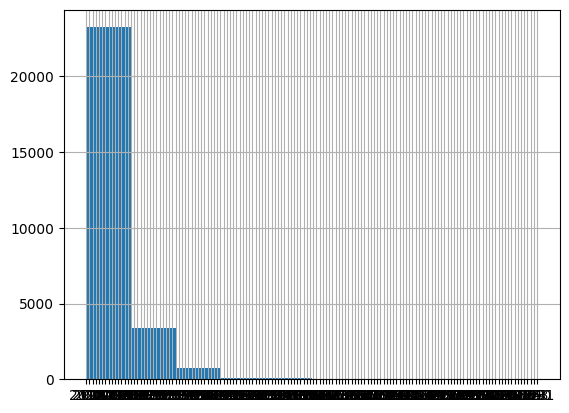

In [ ]:
df['founded_at'].hist()

In [ ]:
founded_at_counts = df['founded_at'].value_counts()

In [ ]:
founded_at_counts

,count
founded_at,
2011,3315
2012,3253
2010,2698
2009,2198
2013,2175
...,...
1941,1
1861,1
1845,1


In [ ]:
df['founded_at'].info()

<class 'pandas.core.series.Series'>
Index: 35155 entries, 0 to 49437
Series name: founded_at
Non-Null Count  Dtype 
--------------  ----- 
27704 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [ ]:
var = df[df['founded_at']>='1994']

In [ ]:
len(var)/len(df)

0.7549423979519272

In [ ]:
df_new = df[df['founded_at']>='1994']

In [ ]:
df_new['new_founded_at'] = df_new['founded_at'].apply(lambda x: x if pd.notna(x) and x.isdigit() and int(x) >= 2000 else 'OTHER')

<ipython-input-191-d6a0b1044de4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['new_founded_at'] = df_new['founded_at'].apply(lambda x: x if pd.notna(x) and x.isdigit() and int(x) >= 2000 else 'OTHER')


In [ ]:
# prompt: rotate labels by 45 degrees

df_new.head()

,name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,E-Commerce,Enterprise Software,Games,Mobile,Other,Security,Social Media,Software,Web Hosting,new_founded_at
0,#waywire,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012,...,0,0,0,0,5,0,1,0,0,2012
3,(In)Touch Network,Electronics,1500000.0,operating,GBR,NaN,London,London,1,2011,...,1,0,0,1,10,0,0,0,0,2011
5,.Club Domains,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,2011,...,0,0,0,0,2,0,0,1,0,2011
7,0-6.com,Curated Web,2000000.0,operating,NaN,NaN,NaN,NaN,1,2007,...,0,0,0,0,2,0,0,0,0,2007
15,10 Minutes With,Education,4400000.0,operating,GBR,NaN,London,London,2,2013,...,0,0,0,0,3,0,0,0,0,2013


In [ ]:
#looking at funding_rounds data
df_new['funding_rounds'].value_counts()

,count
funding_rounds,
1,12862
2,6601
3,3369
4,1749
5,901
6,513
7,231
8,138
9,75


In [ ]:
df = df_new.copy()

In [ ]:
len(df[df['round_A']>1]), len(df[df['round_B']>1]), len(df[df['round_C']>1]), len(df[df['round_D']>1]), len(df[df['round_E']>1]), len(df[df['round_F']>1]), len(df[df['round_G']>1])

(7344, 4614, 2446, 1132, 470, 158, 33)

In [ ]:
df[df['round_A']>1].value_counts()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,count
name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,Advertising,Analytics,Biotechnology,Curated Web,E-Commerce,Enterprise Software,Games,Mobile,Other,Security,Social Media,Software,Web Hosting,new_founded_at,
1000memories,Curated Web,2535000.0,acquired,USA,CA,SF Bay Area,San Francisco,2,2010,2010-07,2010-Q3,2010.0,2010-01-01,2011-02-16,15000,2520000,0,0,0,0,0,0,0,0,0,0,0,2520000,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,2,0,0,0,0,2010,1
Quovo,Financial Services,1400000.0,operating,USA,NY,New York City,New York,1,2009,2009-01,2009-Q1,2009.0,2013-12-12,2013-12-12,0,1400000,0,0,0,0,0,0,0,0,0,0,0,1400000,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,4,0,0,0,0,2009,1
REACH Health,Health Care,18540271.0,operating,USA,GA,Atlanta,Alpharetta,5,2006,2006-01,2006-Q1,2006.0,2010-09-27,2014-04-07,0,11140271,0,0,0,3000000,0,0,4400000,0,0,0,0,5000000,4000000,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,0,0,0,0,2006,1
RE2,Defense,2250000.0,operating,USA,PA,Pittsburgh,Pittsburgh,2,2001,2001-01,2001-Q1,2001.0,2014-01-29,2014-08-18,0,2250000,0,0,0,0,0,0,0,0,0,0,0,2250000,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,0,0,0,0,2001,1
RBM Technologies,SaaS,9499986.0,operating,USA,MA,Boston,Cambridge,1,2000,2000-01,2000-Q1,2000.0,2014-04-02,2014-04-02,0,9499986,0,0,0,0,0,0,0,0,0,0,0,9499986,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,0,0,1,0,2000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GamerDNA,Games,3000000.0,acquired,USA,MA,Boston,Cambridge,2,2006,2006-10,2006-Q4,2006.0,2007-07-01,2008-04-18,0,3000000,0,0,0,0,0,0,0,0,0,0,0,3000000,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,2,0,0,0,0,2006,1
GameSkinny,Games,2300000.0,operating,USA,VA,Richmond,Richmond,2,2012,2012-01,2012-Q1,2012.0,2006-01-01,2013-03-19,0,2300000,0,0,0,0,0,0,0,0,0,0,0,300000,2000000,1,1,1,1,1,1,0,0,0,0,0,0,1,0,5,0,0,0,0,2012,1
GameSalad,Software,7100000.0,operating,USA,CA,SF Bay Area,San Francisco,4,2007,2007-08,2007-Q3,2007.0,2010-07-14,2012-03-09,0,7100000,0,0,0,0,0,0,0,0,0,0,0,7100000,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,10,0,0,1,0,2007,1


max_round_A: 225000000
min_round_A: 4


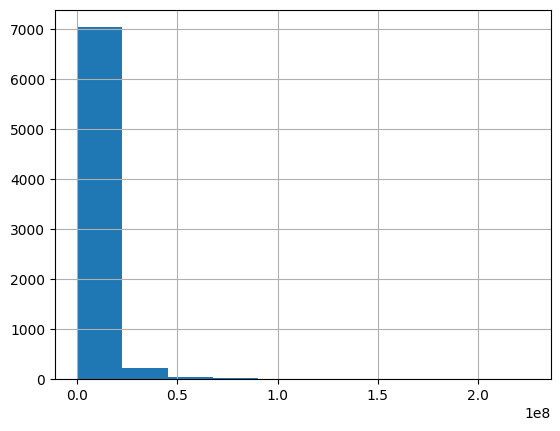

In [ ]:
df[df['round_A']> 1e5]['round_A'].hist()
print(f'max_round_A: {df[df["round_A"]>1e5]["round_A"].max()}')
print(f'min_round_A: {df[df["round_A"]>1]["round_A"].min()}')

In [ ]:
df['round_A']

#cummulating funding at each step (round_G to round_B) recieved from round_G to round_A


,round_A
0,1
3,1
5,1
7,2000000
15,4000000
...,...
49429,1
49430,7991547
49432,2686600
49433,1


In [ ]:
df[df['round_A'] >1e8]

,name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,E-Commerce,Enterprise Software,Games,Mobile,Other,Security,Social Media,Software,Web Hosting,new_founded_at
332,55tuan.com,E-Commerce,200000000.0,operating,CHN,NaN,Beijing,Beijing,2,2010,...,1,0,0,0,2,0,0,0,0,2010
956,Adaptimmune,Biotechnology,107500000.0,operating,GBR,NaN,Oxton,Oxton,2,2008,...,0,0,0,0,2,0,0,0,0,2008
1683,AirWatch,Mobile,225000000.0,acquired,USA,GA,Atlanta,Atlanta,2,2003,...,0,0,0,1,3,0,0,0,0,2003
4910,Better Place,Clean Technology,925000000.0,acquired,USA,CA,SF Bay Area,Palo Alto,6,2007,...,0,0,0,0,3,0,0,0,0,2007
22281,Juno Therapeutics,Health Care,310000000.0,operating,USA,WA,Seattle,Seattle,3,2013,...,0,0,0,0,4,0,0,0,0,2013
27703,Mozido,Enterprise Software,307161792.0,operating,USA,NY,New York City,New York,4,2005,...,0,1,0,0,2,0,0,0,0,2005
30058,Official Limited Virtual,Music,170604000.0,closed,GBR,NaN,London,London,1,2009,...,0,0,0,0,3,0,0,0,0,2009
30905,Oscar,Insurance,150000000.0,operating,USA,NY,New York City,New York,3,2013,...,0,0,0,0,4,0,0,0,0,2013
35484,Renrendai,Finance,133205128.0,operating,CHN,NaN,Beijing,Beijing,2,2010,...,0,0,0,0,3,0,0,0,0,2010
44868,Ule,Mobile,110000000.0,operating,CHN,NaN,CHN - Other,NaN,1,2009,...,1,0,0,1,2,0,0,0,0,2009


In [ ]:
len(df[df['round_B']> df['round_A']]), len(df)

(4129, 26540)

In [ ]:
df.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'Advertising', 'Analytics', 'Biotechnology', 'Curated Web',
       'E-Commerce', 'Enterprise Software', 'Games', 'Mobile', 'Other',
       'Security', 'Social Media', 'Software', 'Web Hosting',
       'new_founded_at'],
      dtype='object')

In [ ]:
column_stack = ['round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']

reversed_col = list(column_stack[::-1])

cum_funding = df[reversed_col].cumsum(axis=1)
cum_funding.columns = [f'cum_{col}' for col in reversed_col]
df_new = pd.concat([df, cum_funding], axis=1)
df_new.head()

,name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,Web Hosting,new_founded_at,cum_round_H,cum_round_G,cum_round_F,cum_round_E,cum_round_D,cum_round_C,cum_round_B,cum_round_A
0,#waywire,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012,...,0,2012,1,2,3,4,5,6,7,8
3,(In)Touch Network,Electronics,1500000.0,operating,GBR,NaN,London,London,1,2011,...,0,2011,1,2,3,4,5,6,7,8
5,.Club Domains,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,2011,...,0,2011,1,2,3,4,5,6,7000006,7000007
7,0-6.com,Curated Web,2000000.0,operating,NaN,NaN,NaN,NaN,1,2007,...,0,2007,1,2,3,4,5,6,7,2000007
15,10 Minutes With,Education,4400000.0,operating,GBR,NaN,London,London,2,2013,...,0,2013,1,2,3,4,5,6,7,4000007


In [ ]:
df_new.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'Advertising', 'Analytics', 'Biotechnology', 'Curated Web',
       'E-Commerce', 'Enterprise Software', 'Games', 'Mobile', 'Other',
       'Security', 'Social Media', 'Software', 'Web Hosting', 'new_founded_at',
       'cum_round_H', 'cum_round_G', 'cum_round_F', 'cum_round_E',
       'cum_round_D', 'cum_round_C', 'cum_round_B', 'cum_round_A'],
      dtype='object')

In [ ]:
#finding growth rate at each funding_round
growth_columns = {}

# Iterate through the rounds to compute growth
for i, round_name in enumerate(column_stack):
    if i < len(column_stack) - 1:  # Skip the last round (round_G), as it has no cum_round_Y
        next_cumulative_col = f"cum_{column_stack[i+1]}"
        growth_col_name = f"growth_at_{round_name}"
        growth_columns[growth_col_name] = (-df[round_name] + cum_funding[next_cumulative_col]) / df[round_name]

# Create a DataFrame for growth columns
growth_df = pd.DataFrame(growth_columns)

growth_df.head()


,growth_at_round_A,growth_at_round_B,growth_at_round_C,growth_at_round_D,growth_at_round_E,growth_at_round_F,growth_at_round_G
0,6.000000e+00,5.000000,4.0,3.0,2.0,1.0,0.0
3,6.000000e+00,5.000000,4.0,3.0,2.0,1.0,0.0
5,7.000005e+06,-0.999999,4.0,3.0,2.0,1.0,0.0
7,-9.999965e-01,5.000000,4.0,3.0,2.0,1.0,0.0
15,-9.999982e-01,5.000000,4.0,3.0,2.0,1.0,0.0


In [ ]:
df_new = pd.concat([df_new, growth_df], axis=1)

In [ ]:
df_new.head()

,name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,cum_round_C,cum_round_B,cum_round_A,growth_at_round_A,growth_at_round_B,growth_at_round_C,growth_at_round_D,growth_at_round_E,growth_at_round_F,growth_at_round_G
0,#waywire,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012,...,6,7,8,6.000000e+00,5.000000,4.0,3.0,2.0,1.0,0.0
3,(In)Touch Network,Electronics,1500000.0,operating,GBR,NaN,London,London,1,2011,...,6,7,8,6.000000e+00,5.000000,4.0,3.0,2.0,1.0,0.0
5,.Club Domains,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,2011,...,6,7000006,7000007,7.000005e+06,-0.999999,4.0,3.0,2.0,1.0,0.0
7,0-6.com,Curated Web,2000000.0,operating,NaN,NaN,NaN,NaN,1,2007,...,6,7,2000007,-9.999965e-01,5.000000,4.0,3.0,2.0,1.0,0.0
15,10 Minutes With,Education,4400000.0,operating,GBR,NaN,London,London,2,2013,...,6,7,4000007,-9.999982e-01,5.000000,4.0,3.0,2.0,1.0,0.0


<Axes: >

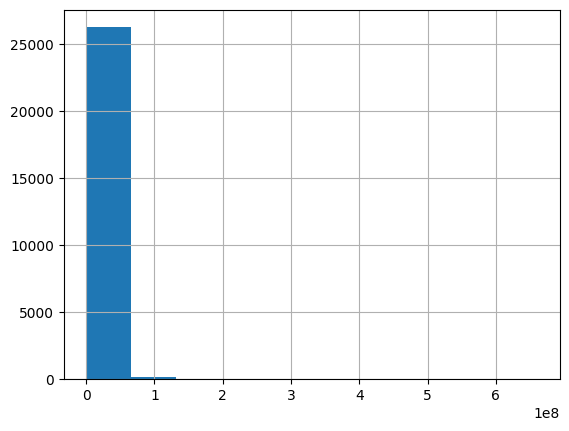

In [ ]:
df_new['growth_at_round_A'].hist()

In [ ]:
df_new.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'Advertising', 'Analytics', 'Biotechnology', 'Curated Web',
       'E-Commerce', 'Enterprise Software', 'Games', 'Mobile', 'Other',
       'Security', 'Social Media', 'Software', 'Web Hosting', 'new_founded_at',
       'cum_round_H', 'cum_round_G', 'cum_round_F', 'cum_round_E',
       'cum_round_D', 'cum_round_C', 'cum_round_B', 'cum_round_A',
       'growth_at_round_A', 'growth_at_round_B', 'growth_at_round_C',
  

In [ ]:
len(df_new[df_new['growth_at_round_A'] > 1e7]['growth_at_round_A'])

1842

In [ ]:
#df_new['target'] = cum_funding.max(axis=1).apply(lambda x: x if x > 5e5 else 0)


In [ ]:
# df_thresh = df_new[(df_new['target'] > 0 ) & (df_new['target']< 1e8)]
# df_thresh['target'].hist()
# min(df_thresh['target']), max(df_new['target'])

In [ ]:
# df_new[(df_new['target'] == 0) & (df['funding_total_usd'] > 1e9)]['funding_total_usd'].hist()

In [ ]:
df_new.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'Advertising', 'Analytics', 'Biotechnology', 'Curated Web',
       'E-Commerce', 'Enterprise Software', 'Games', 'Mobile', 'Other',
       'Security', 'Social Media', 'Software', 'Web Hosting', 'new_founded_at',
       'cum_round_H', 'cum_round_G', 'cum_round_F', 'cum_round_E',
       'cum_round_D', 'cum_round_C', 'cum_round_B', 'cum_round_A',
       'growth_at_round_A', 'growth_at_round_B', 'growth_at_round_C',
  

In [ ]:
input_columns = ['market', 'region', 'founded_year']

In [ ]:
funding_columns = ['seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']#, 'funding_rounds']

In [ ]:
for i in funding_columns:
  print(len(df_new[df_new[i]> 1e5]))

8196
16644
205
514
370
2964
2411
483
962
160
39
16
125
7325
4608
2445
1130
470
158
33
4


In [ ]:
len(df_new)

26540

In [ ]:
df['venture'].head()

,venture
0,0
3,0
5,7000000
7,2000000
15,4000000


In [ ]:
funding_columns.remove('round_H')

In [ ]:
df.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'Advertising', 'Analytics', 'Biotechnology', 'Curated Web',
       'E-Commerce', 'Enterprise Software', 'Games', 'Mobile', 'Other',
       'Security', 'Social Media', 'Software', 'Web Hosting',
       'new_founded_at'],
      dtype='object')

<Axes: >

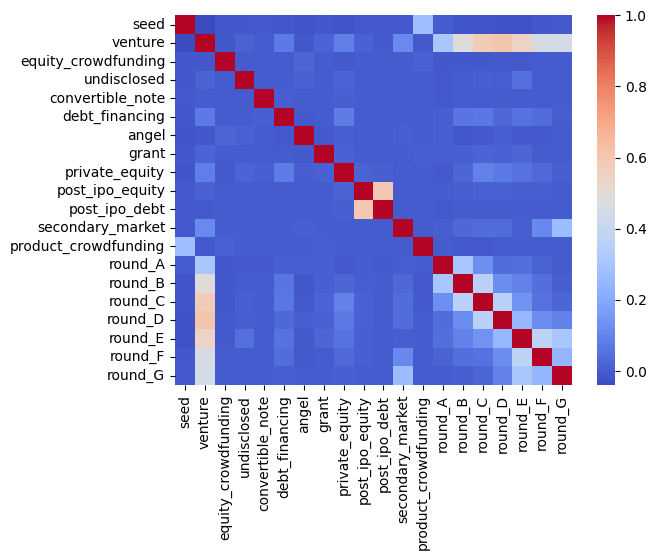

In [ ]:
#visualizing correlation between funding_features
correlation_matrix = df[funding_columns].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

In [ ]:
import numpy as np
np.mean(df[df['status']=='acquired']['funding_total_usd'])

24153653.20884521

In [ ]:
len(df_new[df_new['cum_round_A']>1e5])

10230

In [ ]:
updated_investments_df['founded_year']

,founded_year
0,2012.0
1,NaN
2,2012.0
3,2011.0
4,2014.0
...,...
49433,2013.0
49434,NaN
49435,2012.0
49436,NaN


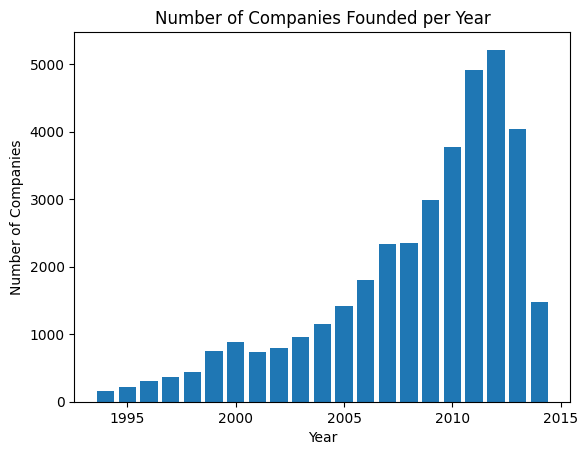

In [ ]:
val_counts = updated_investments_df[updated_investments_df['founded_year']>= 1994]['founded_year'].value_counts()

plt.bar(val_counts.index, val_counts.values)
# val_counts
plt.xlabel('Year')
plt.ylabel('Number of Companies')
plt.title('Number of Companies Founded per Year')
plt.show()

<Axes: >

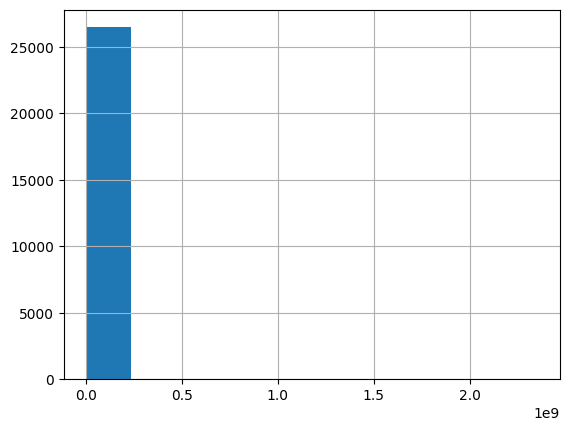

In [ ]:
df['venture'].hist()

In [ ]:
df.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'Advertising', 'Analytics', 'Biotechnology', 'Curated Web',
       'E-Commerce', 'Enterprise Software', 'Games', 'Mobile', 'Other',
       'Security', 'Social Media', 'Software', 'Web Hosting',
       'new_founded_at'],
      dtype='object')

In [ ]:
df_new.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'Advertising', 'Analytics', 'Biotechnology', 'Curated Web',
       'E-Commerce', 'Enterprise Software', 'Games', 'Mobile', 'Other',
       'Security', 'Social Media', 'Software', 'Web Hosting', 'new_founded_at',
       'cum_round_H', 'cum_round_G', 'cum_round_F', 'cum_round_E',
       'cum_round_D', 'cum_round_C', 'cum_round_B', 'cum_round_A',
       'growth_at_round_A', 'growth_at_round_B', 'growth_at_round_C',
  

In [ ]:
#dropping columns :
df_new = df_new.drop(columns=['cum_round_H', 'cum_round_G', 'cum_round_F',
       'cum_round_E', 'cum_round_D', 'cum_round_C', 'cum_round_B',
       'cum_round_A'])
#, 'growth_at_round_A', 'growth_at_round_B',
      #  'growth_at_round_C', 'growth_at_round_D', 'growth_at_round_E',
      #  'growth_at_round_F', 'growth_at_round_G'])


In [ ]:
df_new.head()

,name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,Software,Web Hosting,new_founded_at,growth_at_round_A,growth_at_round_B,growth_at_round_C,growth_at_round_D,growth_at_round_E,growth_at_round_F,growth_at_round_G
0,#waywire,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012,...,0,0,2012,6.000000e+00,5.000000,4.0,3.0,2.0,1.0,0.0
3,(In)Touch Network,Electronics,1500000.0,operating,GBR,NaN,London,London,1,2011,...,0,0,2011,6.000000e+00,5.000000,4.0,3.0,2.0,1.0,0.0
5,.Club Domains,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,2011,...,1,0,2011,7.000005e+06,-0.999999,4.0,3.0,2.0,1.0,0.0
7,0-6.com,Curated Web,2000000.0,operating,NaN,NaN,NaN,NaN,1,2007,...,0,0,2007,-9.999965e-01,5.000000,4.0,3.0,2.0,1.0,0.0
15,10 Minutes With,Education,4400000.0,operating,GBR,NaN,London,London,2,2013,...,0,0,2013,-9.999982e-01,5.000000,4.0,3.0,2.0,1.0,0.0


In [ ]:
#converting country_code into dummies:

#df_new = pd.get_dummies(df_new, columns=['country_code'])

#looking at distribution of country_code:
df['country_code'].value_counts()
#keep all country codes > 250 and put everything else into 'other'


,count
country_code,
USA,17148
GBR,1451
CAN,754
FRA,558
CHN,493
...,...
TTO,1
TUN,1
NPL,1


In [ ]:
# Split the strings into countries
countries = df['country_code']#.str.split('|').explode()

# Count the occurrences of each category
country_counts = countries.value_counts()

thresh=150
filtered_country = countries[countries.isin(countries.value_counts()[countries.value_counts() > thresh].index)]

#removing "" category
# filtered_categories = filtered_categories[filtered_categories != ""]


In [ ]:
filtered_country.value_counts()

,count
country_code,
USA,17148
GBR,1451
CAN,754
FRA,558
CHN,493
ISR,480
DEU,429
IND,407
ESP,321


In [ ]:
countries_keep = filtered_country.value_counts().keys()

In [ ]:
df_new['country'] = df_new['country_code'].fillna('other')
df_new['country'] = df_new['country_code'].apply(lambda x: x if x in countries_keep else 'other' )

df_new['country'].value_counts()

dummies = pd.get_dummies(df_new['country'] , prefix='', prefix_sep='', drop_first=True)
df_new = pd.concat([df_new, dummies], axis=1)
df_new.drop(columns=['country_code'], inplace=True)

In [ ]:
df_new.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'state_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'Advertising', 'Analytics', 'Biotechnology', 'Curated Web',
       'E-Commerce', 'Enterprise Software', 'Games', 'Mobile', 'Other',
       'Security', 'Social Media', 'Software', 'Web Hosting', 'new_founded_at',
       'growth_at_round_A', 'growth_at_round_B', 'growth_at_round_C',
       'growth_at_round_D', 'growth_at_round_E', 'growth_at_round_F',
       'growth_at_round_G', 'country', 'CAN', 'CHN', 'DEU', 'ESP', 'FRA',
       '

In [ ]:

markets = df['market']#.str.split('|').explode()

# Count the occurrences of each category
market_counts = markets.value_counts()

thresh=150
filtered_markets = markets[markets.isin(markets.value_counts()[markets.value_counts() > thresh].index)]
markets_keep = filtered_markets.value_counts().keys()


In [ ]:
df_new['market'] = df_new['market'].fillna('other')
df_new['market'] = df_new['market'].apply(lambda x: x if x in markets_keep else 'other' )

df_new['market'].value_counts()

dummies = pd.get_dummies(df_new['market'] , prefix='market', prefix_sep='', drop_first=True)
df_new = pd.concat([df_new, dummies], axis=1)
df_new.drop(columns=['market'], inplace=True)

In [ ]:
print(df_new.columns)

Index(['name', 'funding_total_usd', 'status', 'state_code', 'region', 'city',
       'funding_rounds', 'founded_at', 'founded_month', 'founded_quarter',
       ...
       'market SaaS ', 'market Search ', 'market Security ',
       'market Semiconductors ', 'market Social Media ', 'market Software ',
       'market Technology ', 'market Travel ', 'market Web Hosting ',
       'marketother'],
      dtype='object', length=102)


In [ ]:
df_new.head()

,name,funding_total_usd,status,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,...,market SaaS,market Search,market Security,market Semiconductors,market Social Media,market Software,market Technology,market Travel,market Web Hosting,marketother
0,#waywire,1750000.0,acquired,NY,New York City,New York,1,2012,2012-06,2012-Q2,...,False,False,False,False,False,False,False,False,False,False
3,(In)Touch Network,1500000.0,operating,NaN,London,London,1,2011,2011-04,2011-Q2,...,False,False,False,False,False,False,False,False,False,True
5,.Club Domains,7000000.0,NaN,FL,Ft. Lauderdale,Oakland Park,1,2011,2011-10,2011-Q4,...,False,False,False,False,False,True,False,False,False,False
7,0-6.com,2000000.0,operating,NaN,NaN,NaN,1,2007,2007-01,2007-Q1,...,False,False,False,False,False,False,False,False,False,False
15,10 Minutes With,4400000.0,operating,NaN,London,London,2,2013,2013-01,2013-Q1,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_new.drop(columns=['founded_month', 'founded_quarter', 'state_code', 'name', 'city'], inplace=True)

In [ ]:
df_new.head()

,funding_total_usd,status,region,funding_rounds,founded_at,founded_year,first_funding_at,last_funding_at,seed,venture,...,market SaaS,market Search,market Security,market Semiconductors,market Social Media,market Software,market Technology,market Travel,market Web Hosting,marketother
0,1750000.0,acquired,New York City,1,2012,2012.0,2012-06-30,2012-06-30,1750000,0,...,False,False,False,False,False,False,False,False,False,False
3,1500000.0,operating,London,1,2011,2011.0,2011-04-01,2011-04-01,1500000,0,...,False,False,False,False,False,False,False,False,False,True
5,7000000.0,NaN,Ft. Lauderdale,1,2011,2011.0,2013-05-31,2013-05-31,0,7000000,...,False,False,False,False,False,True,False,False,False,False
7,2000000.0,operating,NaN,1,2007,2007.0,2008-03-19,2008-03-19,0,2000000,...,False,False,False,False,False,False,False,False,False,False
15,4400000.0,operating,London,2,2013,2013.0,2013-01-01,2014-10-09,400000,4000000,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_new = df_new[df_new['status'] != 'operating']

In [ ]:
#making df['founded_at'] as dummies
df_new = pd.get_dummies(df_new, columns=['founded_at'])


In [ ]:
df.drop(columns=['founded_at', 'founded_year'])

,name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_month,...,E-Commerce,Enterprise Software,Games,Mobile,Other,Security,Social Media,Software,Web Hosting,new_founded_at
0,#waywire,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012-06,...,0,0,0,0,5,0,1,0,0,2012
3,(In)Touch Network,Electronics,1500000.0,operating,GBR,NaN,London,London,1,2011-04,...,1,0,0,1,10,0,0,0,0,2011
5,.Club Domains,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,2011-10,...,0,0,0,0,2,0,0,1,0,2011
7,0-6.com,Curated Web,2000000.0,operating,NaN,NaN,NaN,NaN,1,2007-01,...,0,0,0,0,2,0,0,0,0,2007
15,10 Minutes With,Education,4400000.0,operating,GBR,NaN,London,London,2,2013-01,...,0,0,0,0,3,0,0,0,0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49429,ZYOMYX,Biotechnology,34275015.0,operating,USA,MO,MO - Other,Fremont,4,1998-01,...,0,0,0,0,2,0,0,0,0,OTHER
49430,Zyraz Technology,Biotechnology,15419877.0,closed,MYS,NaN,MYS - Other,Damansara New Village,4,1994-01,...,0,0,0,0,2,0,0,0,0,OTHER
49432,Zytoprotec,Biotechnology,2686600.0,operating,AUT,NaN,Vienna,Gerasdorf Bei Wien,1,2007-01,...,0,0,0,0,2,0,0,0,0,2007
49433,Zzish,Education,320000.0,operating,GBR,NaN,London,London,1,2013-01,...,0,0,0,0,7,0,0,0,0,2013


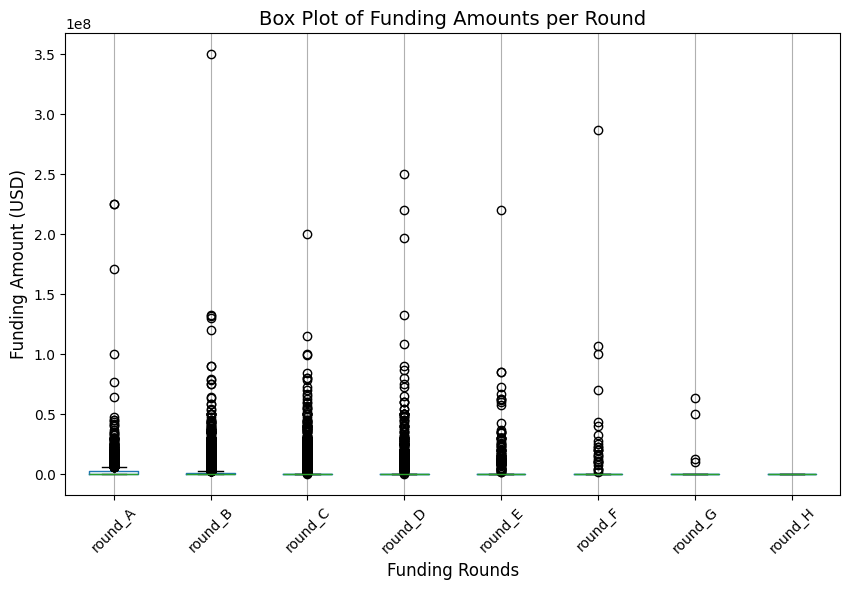

In [ ]:
# Plot the data as a box plot
plt.figure(figsize=(10, 6))
df_new[['round_A', 'round_B', 'round_C', 'round_D','round_E', 'round_F', 'round_G', 'round_H']].boxplot()
plt.title('Box Plot of Funding Amounts per Round', fontsize=14)
plt.xlabel('Funding Rounds', fontsize=12)
plt.ylabel('Funding Amount (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
regions = df['region']#.str.split('|').explode()

# Count the occurrences of each category
region_counts = regions.value_counts()

thresh=150
filtered_regions = regions[regions.isin(regions.value_counts()[regions.value_counts() > thresh].index)]
regions_keep = filtered_regions.value_counts().keys()


In [ ]:
len(filtered_regions.value_counts())

29

In [ ]:
df_new['region'] = df_new['region'].fillna('other')
df_new['region'] = df_new['region'].apply(lambda x: x if x in markets_keep else 'other')

df_new['region'].value_counts()

dummies = pd.get_dummies(df_new['region'] , prefix='region', prefix_sep='', drop_first=True)
df_new = pd.concat([df_new, dummies], axis=1)
df_new.drop(columns=['region'], inplace=True)


In [ ]:
df_new.columns

Index(['funding_total_usd', 'status', 'funding_rounds', 'founded_year',
       'first_funding_at', 'last_funding_at', 'seed', 'venture',
       'equity_crowdfunding', 'undisclosed',
       ...
       'founded_at_2005', 'founded_at_2006', 'founded_at_2007',
       'founded_at_2008', 'founded_at_2009', 'founded_at_2010',
       'founded_at_2011', 'founded_at_2012', 'founded_at_2013',
       'founded_at_2014'],
      dtype='object', length=116)

In [ ]:
funding_columns

['seed',
 'venture',
 'equity_crowdfunding',
 'undisclosed',
 'convertible_note',
 'debt_financing',
 'angel',
 'grant',
 'private_equity',
 'post_ipo_equity',
 'post_ipo_debt',
 'secondary_market',
 'product_crowdfunding',
 'round_A',
 'round_B',
 'round_C',
 'round_D',
 'round_E',
 'round_F',
 'round_G']

In [ ]:
#apply standard scaler to funding columns:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_new[funding_columns] = scaler.fit_transform(df_new[funding_columns])

In [ ]:
df_new.drop(columns = ['founded_year','first_funding_at','last_funding_at','country','new_founded_at'], inplace = True)

In [ ]:
#drop Nan values from status:
df_new = df_new.dropna(subset=['status'])

In [ ]:
df_new.columns

Index(['funding_total_usd', 'status', 'funding_rounds', 'seed', 'venture',
       'equity_crowdfunding', 'undisclosed', 'convertible_note',
       'debt_financing', 'angel',
       ...
       'founded_at_2005', 'founded_at_2006', 'founded_at_2007',
       'founded_at_2008', 'founded_at_2009', 'founded_at_2010',
       'founded_at_2011', 'founded_at_2012', 'founded_at_2013',
       'founded_at_2014'],
      dtype='object', length=111)

In [ ]:
df_new.head()

,funding_total_usd,status,funding_rounds,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,...,founded_at_2005,founded_at_2006,founded_at_2007,founded_at_2008,founded_at_2009,founded_at_2010,founded_at_2011,founded_at_2012,founded_at_2013,founded_at_2014
0,1750000.0,acquired,1,0.07000,0.000000,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
18,500000.0,acquired,1,0.02000,0.000000,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
20,2535000.0,acquired,2,0.00060,0.003252,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
27,1250000.0,acquired,2,0.03000,0.000645,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False
131,118000.0,closed,1,0.00472,0.000000,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
from sklearn.model_selection import train_test_split
# Assuming 'df' is your DataFrame (updated_investments_df in your case)
df = df_new.copy() # Create a copy to avoid modifying the original
df['status'] = df['status'].apply(lambda x : 0 if x == 'closed' else 1 )
# Assuming 'status' is your target variable
y = df['status']
X = df.drop('status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df.to_csv('/content/df.csv')

In [ ]:
df.columns

Index(['funding_total_usd', 'status', 'funding_rounds', 'seed', 'venture',
       'equity_crowdfunding', 'undisclosed', 'convertible_note',
       'debt_financing', 'angel',
       ...
       'founded_at_2005', 'founded_at_2006', 'founded_at_2007',
       'founded_at_2008', 'founded_at_2009', 'founded_at_2010',
       'founded_at_2011', 'founded_at_2012', 'founded_at_2013',
       'founded_at_2014'],
      dtype='object', length=111)

In [ ]:
# Preprocessing
X = df.drop(['status', 'funding_total_usd'], axis=1)  # Adjust features as needed
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Fitting Logistic Regression**

In [ ]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       254
           1       0.66      1.00      0.79       485

    accuracy                           0.66       739
   macro avg       0.33      0.50      0.40       739
weighted avg       0.43      0.66      0.52       739



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


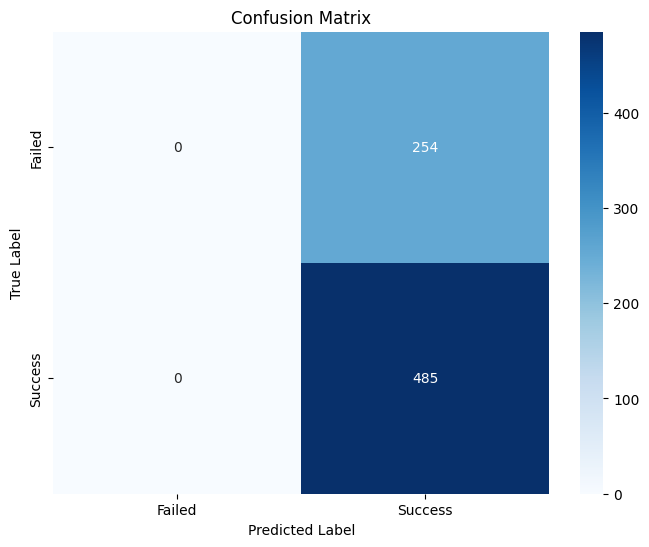


True Negatives: 0
False Positives: 254
False Negatives: 0
True Positives: 485


In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failed', 'Success'],
            yticklabels=['Failed', 'Success'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print metrics
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

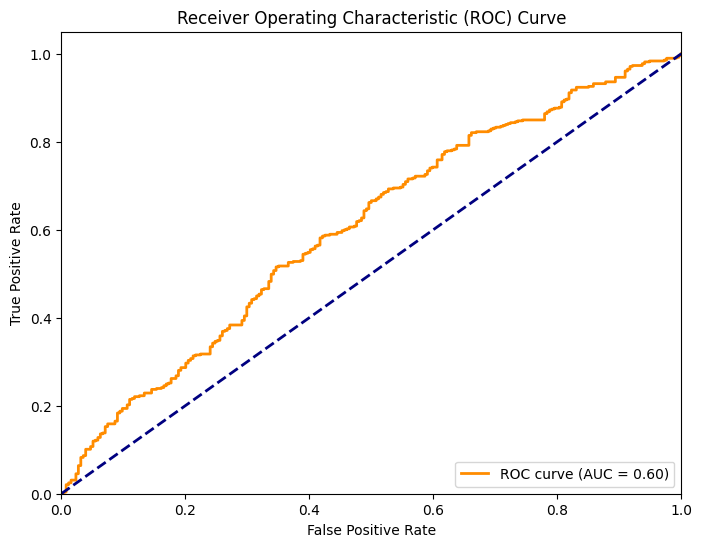

AUC Score: 0.603


In [ ]:
y_pred_proba = model.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.3f}")

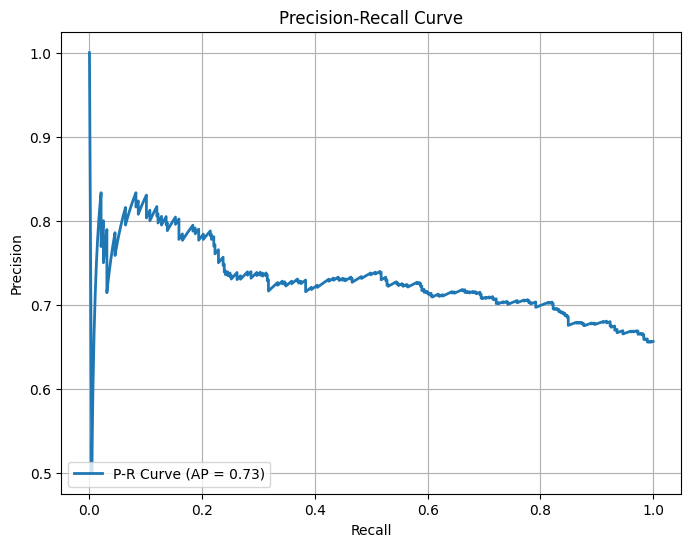

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'P-R Curve (AP = {average_precision:.2f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

**Fitting XG Boost**

In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.57      0.61       254
           1       0.79      0.84      0.81       485

    accuracy                           0.75       739
   macro avg       0.72      0.70      0.71       739
weighted avg       0.74      0.75      0.74       739



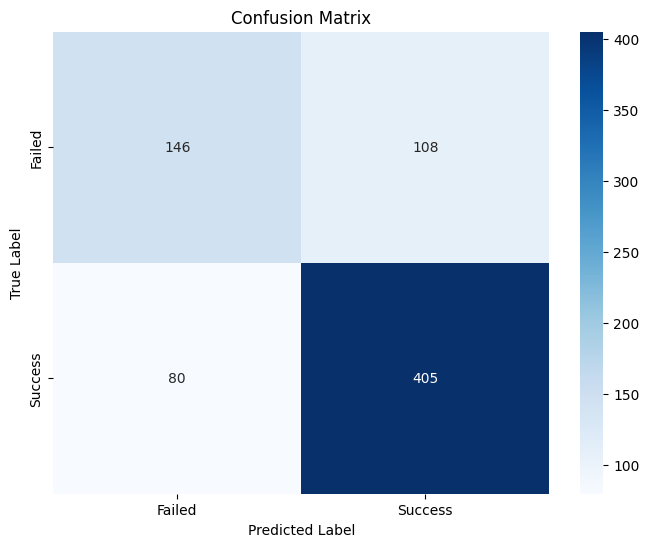


True Negatives: 146
False Positives: 108
False Negatives: 80
True Positives: 405


In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failed', 'Success'],
            yticklabels=['Failed', 'Success'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print metrics
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

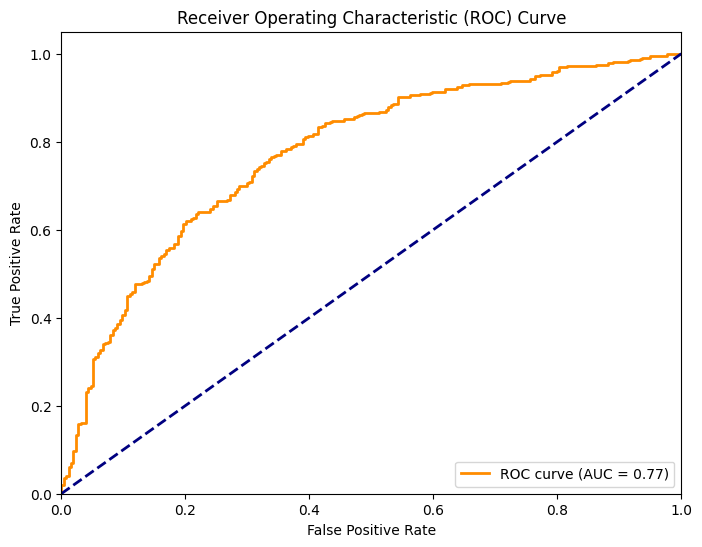

AUC Score: 0.775


In [ ]:
y_pred_proba = xgb_model.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.3f}")

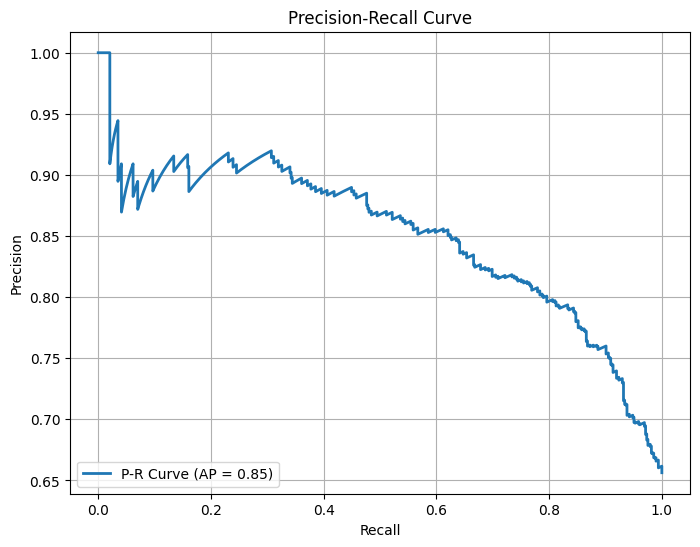

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'P-R Curve (AP = {average_precision:.2f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:,1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.74

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.48      0.56       254
           1       0.76      0.88      0.82       485

    accuracy                           0.74       739
   macro avg       0.72      0.68      0.69       739
weighted avg       0.73      0.74      0.73       739



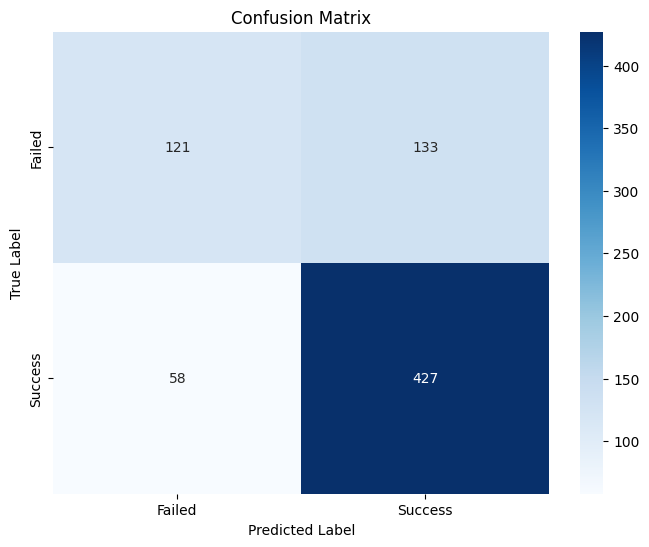


True Negatives: 121
False Positives: 133
False Negatives: 58
True Positives: 427


In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failed', 'Success'],
            yticklabels=['Failed', 'Success'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print metrics
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

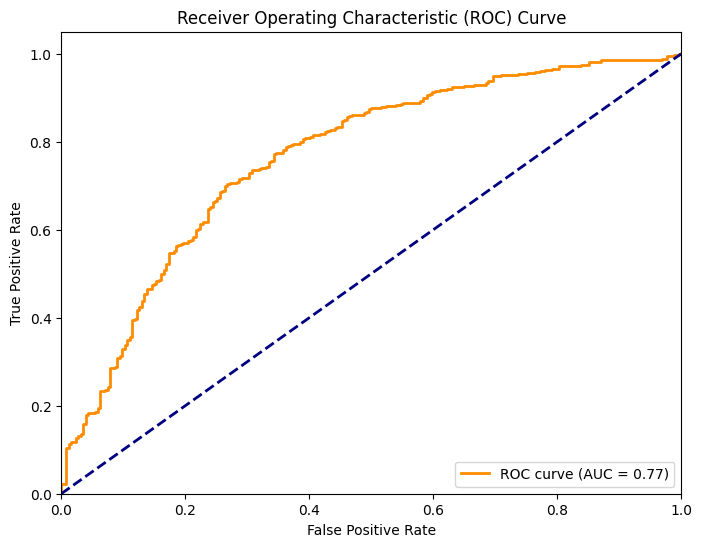

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
              feature  importance
2             venture    0.165779
0      funding_rounds    0.069315
35  growth_at_round_A    0.061620
14            round_A    0.058534
15            round_B    0.057761
36  growth_at_round_B    0.052516
55                USA    0.039896
1                seed    0.038905
16            round_C    0.037866
7               angel    0.037805


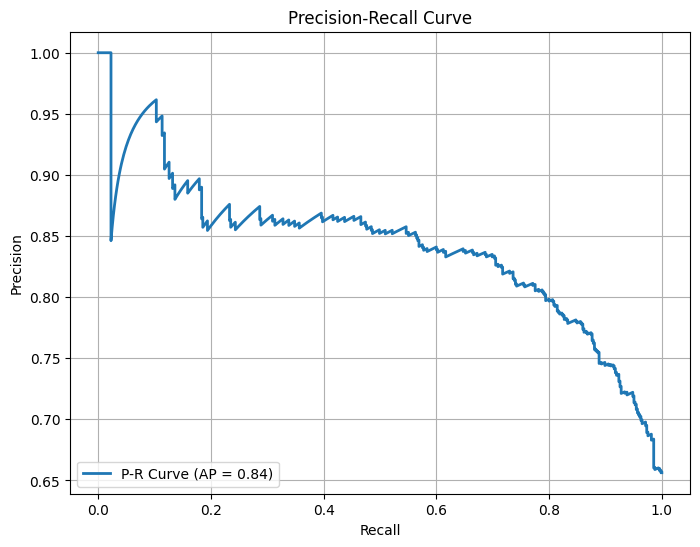

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'P-R Curve (AP = {average_precision:.2f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

**Optimizing Logistic Regression with Lasso**

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=0.001: Accuracy=0.6563, AUC=0.5672


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=0.01: Accuracy=0.6563, AUC=0.6411


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=0.1: Accuracy=0.6888, AUC=0.7099


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=1: Accuracy=0.7037, AUC=0.7347


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=10: Accuracy=0.7077, AUC=0.7353


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C=100: Accuracy=0.7050, AUC=0.7383


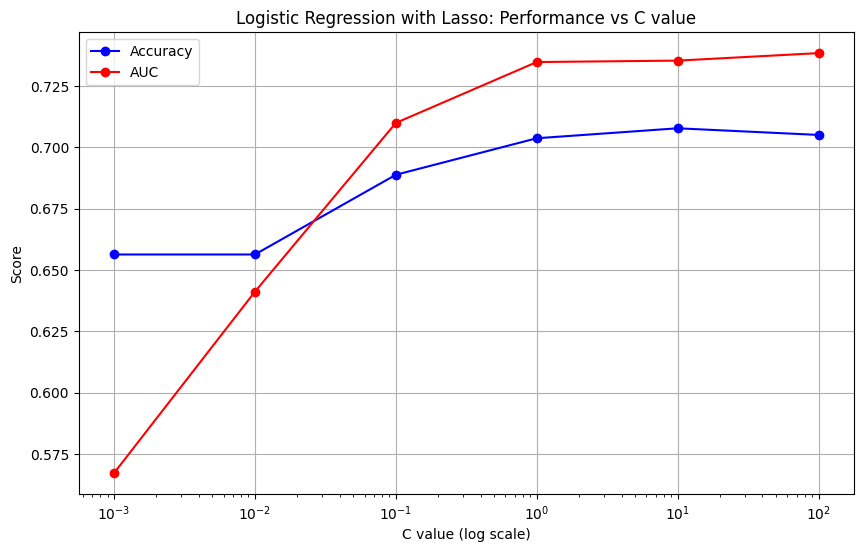


Best C value: 100


In [ ]:
# Define a range of C values
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Lists to store results
accuracies = []
auc_scores = []

for C in C_values:
    # Create and train the model
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    accuracies.append(accuracy)
    auc_scores.append(auc)

    print(f"C={C}: Accuracy={accuracy:.4f}, AUC={auc:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, accuracies, 'b-o', label='Accuracy')
plt.semilogx(C_values, auc_scores, 'r-o', label='AUC')
plt.xlabel('C value (log scale)')
plt.ylabel('Score')
plt.title('Logistic Regression with Lasso: Performance vs C value')
plt.legend()
plt.grid(True)
plt.show()

# Find best C value
best_C = C_values[np.argmax(auc_scores)]
print(f"\nBest C value: {best_C}")

In [ ]:
# Train final model with best C
final_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, random_state=42)
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate final metrics
final_accuracy = accuracy_score(y_test, y_pred)
final_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Final model performance: Accuracy={final_accuracy:.4f}, AUC={final_auc:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(final_model.coef_[0])
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))

Final model performance: Accuracy=0.7050, AUC=0.7383

Top 10 most important features:
                feature  importance
12     secondary_market   31.775451
19              round_F   21.228117
15              round_B   11.534340
3   equity_crowdfunding    9.580089
9        private_equity    8.445694
2               venture    7.407725
8                 grant    7.210224
41    growth_at_round_G    6.210820
84   market Technology     5.906235
6        debt_financing    5.794132


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
zero_coef_features = X.columns[np.abs(final_model.coef_[0]) == 0]
print("\nFeatures with zero coefficients:", zero_coef_features)


# Drop features with zero coefficients
X_train_refit = X_train.drop(columns=zero_coef_features)
X_test_refit = X_test.drop(columns=zero_coef_features)

# Refit the model
refitted_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, random_state=42)
refitted_model.fit(X_train_refit, y_train)


Features with zero coefficients: Index([], dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(C=100, penalty='l1', random_state=42, solver='liblinear')

**Fitting XGBoost + Logistic Ensemble**

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Ensemble Accuracy: 0.75


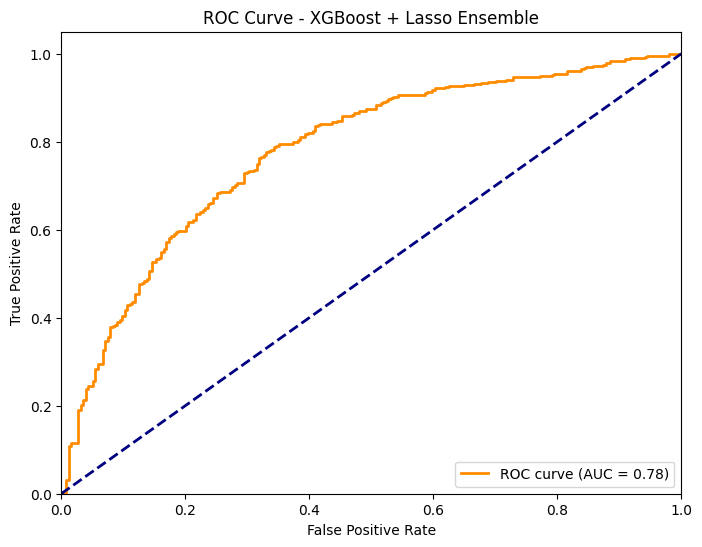

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize base models
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    random_state=42
)

lasso_model = LogisticRegression(
    penalty='l1',
    C=1,
    solver='liblinear',
    random_state=42
)

# Create voting classifier
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lasso', lasso_model)
    ],
    voting='soft'
)

# Train the ensemble
ensemble.fit(X_train, y_train)

# Make predictions
y_pred = ensemble.predict(X_test)
y_pred_proba = ensemble.predict_proba(X_test)[:,1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy:.2f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost + Lasso Ensemble')
plt.legend(loc="lower right")
plt.show()




**Fitting XGBoost + Random Forests + Logistic Ensemble**

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Ensemble Accuracy: 0.75

Individual Model Accuracies:
XGBoost: 0.75
Random Forest: 0.75
Lasso: 0.70


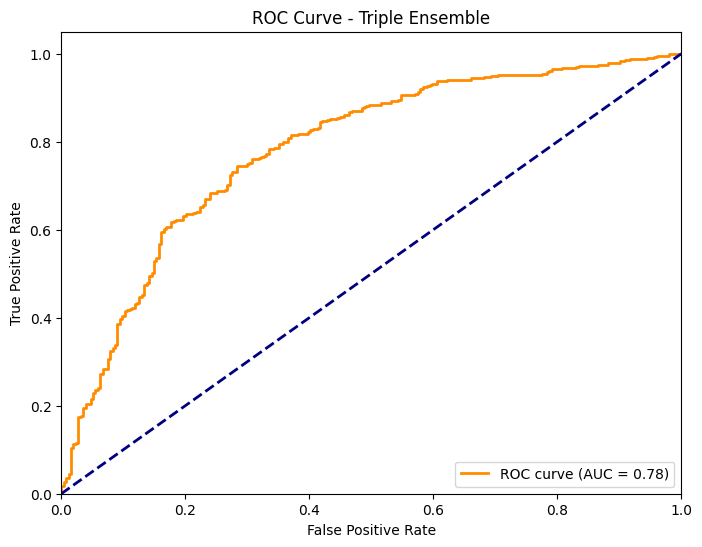

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize base models
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

lasso_model = LogisticRegression(
    penalty='l1',
    C=1,
    solver='liblinear',
    random_state=42
)

# Train individual models first
xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

# Create voting classifier
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lasso', lasso_model)
    ],
    voting='soft',
    weights=[0.4, 0.4, 0.2]  # Giving more weight to XGBoost and Random Forest
)

# Train the ensemble
ensemble.fit(X_train, y_train)

# Make predictions
y_pred = ensemble.predict(X_test)
y_pred_proba = ensemble.predict_proba(X_test)[:,1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy:.2f}")

# Get individual model predictions
xgb_pred = xgb_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
lasso_pred = lasso_model.predict(X_test)

print("\nIndividual Model Accuracies:")
print(f"XGBoost: {accuracy_score(y_test, xgb_pred):.2f}")
print(f"Random Forest: {accuracy_score(y_test, rf_pred):.2f}")
print(f"Lasso: {accuracy_score(y_test, lasso_pred):.2f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Triple Ensemble')
plt.legend(loc="lower right")
plt.show()

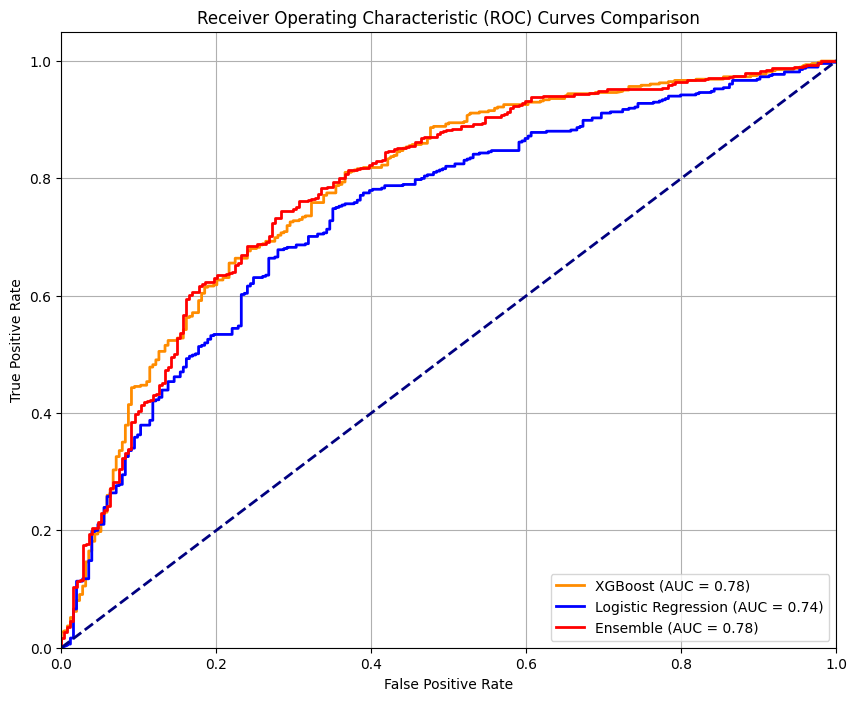

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predictions from all models
xgb_proba = xgb_model.predict_proba(X_test)[:,1]
lr_proba = final_model.predict_proba(X_test)[:,1]
# svm_proba = svm_model.predict_proba(X_test)[:,1]
ensemble_proba = ensemble.predict_proba(X_test)[:,1]

# Calculate ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
# fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_proba)
fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_proba)

# Calculate AUC scores
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_lr = auc(fpr_lr, tpr_lr)
# auc_svm = auc(fpr_svm, tpr_svm)
auc_ens = auc(fpr_ens, tpr_ens)

# Plot all ROC curves
plt.figure(figsize=(10,8))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
# plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot(fpr_ens, tpr_ens, color='red', lw=2, label=f'Ensemble (AUC = {auc_ens:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()